This is a Codecademy data schence project. All datasets are provided by Codecademy.

Currently, when a visitor to MuscleHub, a fancy gym, is considering buying a membership, he or she follows the following steps:
1.	Take a fitness test with a personal trainer
2.	Fill out an application for the gym
3.	Send in their payment for their first month’s membership

Visitors will randomly be assigned to one of two groups:
- Group A will still be asked to take a fitness test with a personal trainer
- Group B will skip the fitness test and proceed directly to the application

**My hypothesis is that visitors assigned to Group B will be more likely to eventually purchase a membership to MuscleHub.**

In [1]:
from codecademySQL import sql_query

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from math import sqrt
from numpy import mean
import scipy.stats as stats
from scipy.stats import sem, t, ttest_ind, chi2, chi2_contingency

In [2]:
# Examine visits 
sql_query('''
SELECT *
FROM visits
LIMIT 5
''')

,index,first_name,last_name,email,gender,visit_date
0,0,Karen,Manning,Karen.Manning@gmail.com,female,5-1-17
1,1,Annette,Boone,AB9982@gmail.com,female,5-1-17
2,2,Salvador,Merritt,SalvadorMerritt12@outlook.com,male,5-1-17
3,3,Martha,Maxwell,Martha.Maxwell@gmail.com,female,5-1-17
4,4,Andre,Mayer,AndreMayer90@gmail.com,male,5-1-17


In [3]:
# Examine fitness_tests 
sql_query('''
SELECT *
FROM fitness_tests
LIMIT 5
''')

,index,first_name,last_name,email,gender,fitness_test_date
0,0,Kim,Walter,KimWalter58@gmail.com,female,2017-07-03
1,1,Tom,Webster,TW3857@gmail.com,male,2017-07-02
2,2,Marcus,Bauer,Marcus.Bauer@gmail.com,male,2017-07-01
3,3,Roberta,Best,RB6305@hotmail.com,female,2017-07-02
4,4,Carrie,Francis,CF1896@hotmail.com,female,2017-07-05


In [4]:
# Examine applications 
sql_query('''
SELECT *
FROM applications
LIMIT 5
''')

,index,first_name,last_name,email,gender,application_date
0,0,Roy,Abbott,RoyAbbott32@gmail.com,male,2017-08-12
1,1,Agnes,Acevedo,AgnesAcevedo1@gmail.com,female,2017-09-29
2,2,Roberta,Acevedo,RA8063@gmail.com,female,2017-09-15
3,3,Darren,Acosta,DAcosta1996@hotmail.com,male,2017-07-26
4,4,Vernon,Acosta,VAcosta1975@gmail.com,male,2017-07-14


In [5]:
# Examine purchases 
sql_query('''
SELECT *
FROM purchases
LIMIT 5
''')

,index,first_name,last_name,email,gender,purchase_date
0,0,Roy,Abbott,RoyAbbott32@gmail.com,male,2017-08-18
1,1,Roberta,Acevedo,RA8063@gmail.com,female,2017-09-16
2,2,Vernon,Acosta,VAcosta1975@gmail.com,male,2017-07-20
3,3,Darren,Acosta,DAcosta1996@hotmail.com,male,2017-07-27
4,4,Dawn,Adkins,Dawn.Adkins@gmail.com,female,2017-08-24


In [6]:
df = sql_query('''
select v.first_name, v.last_name, v.gender, v.email, v.visit_date, f.fitness_test_date, a.application_date, p.purchase_date
from visits v
left join applications a on a.first_name=v.first_name and a.last_name=v.last_name and a.email=v.email
left join fitness_tests f on v.first_name=f.first_name and v.last_name=f.last_name and v.email=f.email
left join purchases p on v.first_name=v.first_name and v.last_name=p.last_name and v.email=p.email
where visit_date>='7-1-17'
''')

df.shape

(5004, 8)

In [7]:
df['ab_test_group'] = np.where(df['fitness_test_date'].isnull(), 'B', 'A')
df.sample(5)

,first_name,last_name,gender,email,visit_date,fitness_test_date,application_date,purchase_date,ab_test_group
2728,Mathew,Farmer,male,MFarmer1979@gmail.com,8-27-17,2017-09-01,None,None,A
814,Johnnie,Delaney,male,Johnnie.Delaney@gmail.com,7-22-17,None,None,None,B
4679,Leon,Thornton,male,Leon.Thornton@gmail.com,9-4-17,2017-09-09,None,None,A
244,Lawrence,Brock,male,LawrenceBrock59@gmail.com,7-13-17,2017-07-15,None,None,A
3682,Priscilla,Santos,female,PSantos1987@outlook.com,9-15-17,None,None,None,B


In [8]:
import datetime as dt
d = df.visit_date.min()
d = dt.datetime.strptime(d, '%m-%d-%y')
d = d.strftime('%Y-%m-%d')
print('The experiment start date is: {}'.format(d))
print('The experiment end date is: {}'.format(df[df.purchase_date.notnull()]['purchase_date'].max()))

The experiment start date is: 2017-07-01
The experiment end date is: 2017-10-10


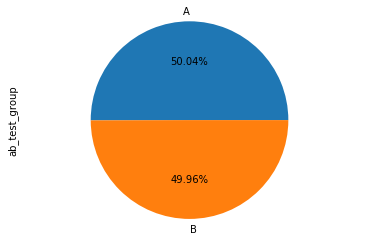

In [9]:
df['ab_test_group'].value_counts().plot.pie(autopct='%.2f%%').axis('equal');

Group A and B have approximately equal sample sizes, so we can proceed with the A/B Testing.


# A/B Testing

In [10]:
df1 = df.copy()

df1['is_applicant']=np.where(df1.application_date.notnull(),1,0)
df1['is_member']=np.where(df1.purchase_date.notnull(),1,0)
df1.sample(5)

,first_name,last_name,gender,email,visit_date,fitness_test_date,application_date,purchase_date,ab_test_group,is_applicant,is_member
2960,Bobby,Puckett,male,BobbyPuckett89@gmail.com,8-4-17,2017-08-06,2017-08-05,2017-08-05,A,1,1
2290,Billie,Hendrix,female,Billie.Hendrix@gmail.com,8-2-17,2017-08-07,None,None,A,0,0
668,Leonard,Madden,male,Leonard.Madden@outlook.com,7-2-17,2017-07-07,None,None,A,0,0
1678,Darren,Montoya,male,Darren.Montoya@gmail.com,8-1-17,2017-08-07,2017-08-02,2017-08-06,A,1,1
4447,Elaine,Bowers,female,Elaine.Bowers@hotmail.com,9-27-17,2017-09-28,None,None,A,0,0


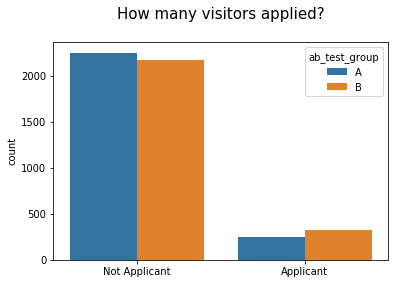

In [11]:
fig, ax = plt.subplots()

ax = sns.countplot(x="is_applicant", hue="ab_test_group", data=df1)
ax.set_xlabel('')
ax.set_xticklabels(['Not Applicant','Applicant'])
ax.set_title('How many visitors applied?',fontsize=15, y=1.08)

plt.show()

It appears that people in Group A (fitness test) are less likely to apply. 

## Hypothesis Test
### Research Question
People from Group A (people who were invited to do a fitness test) were less likely to apply for the gym membership
- Ho: Pa = Pb
- Ha: Pa < Pb

### Check Assumptions
E = n*pi
    - E: expected count
    - n: sample size
    - pi: hypothesized population proportion in the "ith" group    
          (pi = 0.5 for both groups in this case)

In order to use the chi-square distribution to approximate the sampling distribution, all expected counts must be at least five. From `app_pivot` below, we can easily deduct that all expected counts are greater than five.



In [12]:
app_groupby = df1.groupby(['ab_test_group','is_applicant']).first_name.count().reset_index()
app_pivot = app_cnt.pivot_table(values='first_name',index='ab_test_group',columns='is_applicant').reset_index()
app_pivot

NameError: name 'app_cnt' is not defined

In [ ]:
# contingency table
table = [[2254, 250], [2175, 2175]]
print(table)
stat, p, dof, expected = chi2_contingency(table)
print('dof=%d' % dof)
print(expected)

# interpret test-statistic
prob = 0.95
critical = chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
if abs(stat) >= critical:
	print('Dependent (reject Ho)')
else:
	print('Independent (fail to reject Ho)')

# interpret p-value
alpha = 1.0 - prob
print('significance=%.3f, p=%.3f' % (alpha, p))
if p <= alpha:
	print('Dependent (reject Ho)')
else:
	print('Independent (fail to reject Ho)')


We reject the null hypothesis and accept the alternative hypothesis that Group B has a higher rate of applying for membership. Removing the fitness test can help increasing the application rate.

In [ ]:
# extract applicants
df2 = df1[df1['is_applicant']==1]
fig, ax = plt.subplots()

ax = sns.countplot(x="is_member", hue="ab_test_group", data=df2)
ax.set_xlabel('')
ax.set_xticklabels(['Not Member','Member'])
ax.set_title('How many applicants purchased?',fontsize=15, y=1.08)

plt.show()

It appears that applicants in Group A (fitness test) are more likely to purchase. 

## Hypothesis Test
### Research Question
People from Group A (people who were invited to do a fitness test) were more likely to purchase the gym membership
- Ho: Pa = Pb
- Ha: Pa > Pb

### Check Assumptions
E = n*pi
    - E: expected count
    - n: sample size
    - pi: hypothesized population proportion in the "ith" group    
          (pi = 0.5 for both groups in this case)

In order to use the chi-square distribution to approximate the sampling distribution, all expected counts must be at least five. From `app_pay_pivot` below, we can easily deduct that all expected counts are greater than five.



In [ ]:
app_pay_groupby = df2.groupby(['ab_test_group','is_member']).first_name.count().reset_index()
app_pay_pivot = app_pay_groupby.pivot_table(values='first_name',index='ab_test_group',columns='is_member').reset_index()
app_pay_pivot

In [ ]:
# contingency table
table = [[50, 200], [75, 250]]
print(table)
stat, p, dof, expected = chi2_contingency(table)
print('dof=%d' % dof)
print(expected)

# interpret test-statistic
prob = 0.95
critical = chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
if abs(stat) >= critical:
	print('Dependent (reject H0)')
else:
	print('Independent (fail to reject H0)')

# interpret p-value
alpha = 1.0 - prob
print('significance=%.3f, p=%.3f' % (alpha, p))
if p <= alpha:
	print('Dependent (reject H0)')
else:
	print('Independent (fail to reject H0)')


We don't have enough evidence to reject the null hypothesis. Doing fitness test or not has no statiscally significant effect on the gym membership purchasing decision.

In [ ]:
fig, ax = plt.subplots()

ax = sns.countplot(x="is_member", hue="ab_test_group", data=df1)
ax.set_xlabel('')
ax.set_xticklabels(['Not Member','Member'])
ax.set_title('How many visitors purchased?',fontsize=15, y=1.08)

plt.show()

It appears that applicants in Group A (fitness test) are less likely to purchase. 

## Hypothesis Test
### Research Question
People from Group A (people who were invited to do a fitness test) were less likely to purchase the gym membership
- Ho: Pa = Pb
- Ha: Pa < Pb

### Check Assumptions
E = n*pi
    - E: expected count
    - n: sample size
    - pi: hypothesized population proportion in the "ith" group    
          (pi = 0.5 for both groups in this case)

In order to use the chi-square distribution to approximate the sampling distribution, all expected counts must be at least five. From `all_pay_pivot` below, we can easily deduct that all expected counts are greater than five.



In [ ]:
all_pay_groupby = df1.groupby(['ab_test_group','is_member']).first_name.count().reset_index()
all_pay_pivot = all_pay_groupby.pivot_table(values='first_name',index='ab_test_group',columns='is_member').reset_index()
all_pay_pivot

In [ ]:
# contingency table
table = [[2304, 200], [2250, 250]]
print(table)
stat, p, dof, expected = chi2_contingency(table)
print('dof=%d' % dof)
print(expected)

# interpret test-statistic
prob = 0.95
critical = chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
if abs(stat) >= critical:
	print('Dependent (reject H0)')
else:
	print('Independent (fail to reject H0)')

# interpret p-value
alpha = 1.0 - prob
print('significance=%.3f, p=%.3f' % (alpha, p))
if p <= alpha:
	print('Dependent (reject H0)')
else:
	print('Independent (fail to reject H0)')


We reject the null hypothesis and accept the alternative hypothesis that Group B has a higher rate of purchasing the membership. Removing the fitness test can help increasing the purchasing rate.

## Summary
Out of the 3 A/B Testings, the first and the third were proven to be statistically significant. We are confident to conclude that removing the fitness test will help bring more applications and purchases.


In [ ]:
df.head()

In [ ]:
df.visit_date.min()

In [ ]:
df.visit_date.max()

In [ ]:
df[df.purchase_date.notnull()]['purchase_date'].max()